# 02 — Model Training

In this notebook we:
1. Load HAM10000 with our custom PyTorch Dataset
2. Apply data augmentation (albumentations)
3. Fine-tune **EfficientNet-B0** using transfer learning
4. Handle class imbalance with weighted loss
5. Train with early stopping and save the best model

> Training on **CPU** — using 128x128 images and a lightweight model to keep it manageable.

---

In [1]:
import sys
sys.path.append('..')

import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

from src.config import (
    DATA_DIR, MODELS_DIR, RESULTS_DIR, SEED,
    CLASS_NAMES, CLASS_LABELS, NUM_CLASSES,
    IMAGE_SIZE, BATCH_SIZE, LEARNING_RATE, NUM_EPOCHS,
    MODEL_NAME, EARLY_STOPPING_PATIENCE,
)

print(f'PyTorch: {torch.__version__}')
print(f'Device: {"cuda" if torch.cuda.is_available() else "cpu"}')
print(f'Model: {MODEL_NAME}')
print(f'Image size: {IMAGE_SIZE}x{IMAGE_SIZE}')
print(f'Batch size: {BATCH_SIZE}')
print(f'Epochs: {NUM_EPOCHS}')
print(f'Learning rate: {LEARNING_RATE}')
print()
print('Setup complete!')

PyTorch: 2.7.0+cpu
Device: cpu
Model: efficientnet_b0
Image size: 128x128
Batch size: 16
Epochs: 15
Learning rate: 0.0001

Setup complete!


---
## 1. Prepare the Data

Three steps: find all images (split across two folders), stratified train/val/test split (70/15/15), and compute class weights for imbalance.

In [2]:
# The images are split across two folders — let's find them all
image_dirs = [
    DATA_DIR / 'HAM10000_images_part_1',
    DATA_DIR / 'HAM10000_images_part_2',
]

# Load the metadata CSV (contains image_id, diagnosis, age, sex, etc.)
metadata_path = DATA_DIR / 'HAM10000_metadata.csv'
df = pd.read_csv(metadata_path)

# Count images across both folders
total_images = sum(
    len([f for f in d.iterdir() if f.suffix == '.jpg'])
    for d in image_dirs if d.exists()
)

print(f'Found {total_images} images')
print(f'Metadata rows: {len(df)}')

Found 10015 images
Metadata rows: 10015


### Stratified Split

Stratified = each split keeps the same class proportions. Without this, rare classes might have 0 samples in the test set.

In [3]:
from sklearn.model_selection import train_test_split
from src.dataset import HAM10000Dataset, get_transforms

# Stratified split: 70% train, 15% val, 15% test
train_val_df, test_df = train_test_split(
    df, test_size=0.15, stratify=df['dx'], random_state=SEED
)
train_df, val_df = train_test_split(
    train_val_df, test_size=0.176, stratify=train_val_df['dx'], random_state=SEED
    # 0.176 of 85% = 15% of total
)

print(f'Train: {len(train_df)} ({len(train_df)/len(df)*100:.1f}%)')
print(f'Val:   {len(val_df)} ({len(val_df)/len(df)*100:.1f}%)')
print(f'Test:  {len(test_df)} ({len(test_df)/len(df)*100:.1f}%)')
print()

# Verify stratification — percentages should be similar across all splits
print('Class distribution check (should be similar across splits):')
for cls in CLASS_NAMES:
    tr = (train_df['dx'] == cls).sum() / len(train_df) * 100
    va = (val_df['dx'] == cls).sum() / len(val_df) * 100
    te = (test_df['dx'] == cls).sum() / len(test_df) * 100
    print(f'  {CLASS_LABELS[cls]:30s}  train:{tr:5.1f}%  val:{va:5.1f}%  test:{te:5.1f}%')

Train: 7013 (70.0%)
Val:   1499 (15.0%)
Test:  1503 (15.0%)

Class distribution check (should be similar across splits):
  Actinic Keratosis               train:  3.3%  val:  3.3%  test:  3.3%
  Basal Cell Carcinoma            train:  5.1%  val:  5.1%  test:  5.1%
  Benign Keratosis                train: 11.0%  val: 10.9%  test: 11.0%
  Dermatofibroma                  train:  1.2%  val:  1.1%  test:  1.1%
  Melanoma                        train: 11.1%  val: 11.1%  test: 11.1%
  Melanocytic Nevus               train: 66.9%  val: 67.0%  test: 66.9%
  Vascular Lesion                 train:  1.4%  val:  1.4%  test:  1.5%


### PyTorch Datasets & DataLoaders

`HAM10000Dataset` loads images, applies augmentation (training only), and returns tensors. `DataLoader` feeds batches of 16 to the model.

In [4]:
from torch.utils.data import DataLoader

# Create datasets — training gets augmentation, val/test don't
train_dataset = HAM10000Dataset(train_df, image_dirs=image_dirs, transform=get_transforms('train'))
val_dataset = HAM10000Dataset(val_df, image_dirs=image_dirs, transform=get_transforms('val'))
test_dataset = HAM10000Dataset(test_df, image_dirs=image_dirs, transform=get_transforms('test'))

# Create dataloaders (feeds batches of 16 images to the model)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

# Test: grab one batch and check the shapes
images, labels = next(iter(train_loader))
print(f'Batch shape: {images.shape}')   # [16, 3, 128, 128] = 16 images, 3 color channels, 128x128 pixels
print(f'Labels shape: {labels.shape}')  # [16] = one label per image
print(f'Label values: {labels.tolist()}')  # Numbers 0-6 representing the 7 conditions

Batch shape: torch.Size([16, 3, 128, 128])
Labels shape: torch.Size([16])
Label values: [5, 5, 2, 5, 5, 5, 5, 5, 2, 5, 2, 2, 4, 5, 5, 0]


### Class Weights

Without weights, the model just predicts "mole" for everything (67% accuracy, useless). Weights penalize rare-class errors more: `weight = total / (n_classes * class_count)`.

In [5]:
# Compute class weights for imbalanced data
label_counts = train_df['dx'].value_counts()
total = len(train_df)
class_weights = torch.tensor(
    [total / (NUM_CLASSES * label_counts.get(c, 1)) for c in CLASS_NAMES],
    dtype=torch.float32,
)

print('Class weights (higher = rarer class gets more attention):')
for cls, w in zip(CLASS_NAMES, class_weights):
    print(f'  {CLASS_LABELS[cls]:30s}: {w:.2f}')

Class weights (higher = rarer class gets more attention):
  Actinic Keratosis             : 4.37
  Basal Cell Carcinoma          : 2.78
  Benign Keratosis              : 1.30
  Dermatofibroma                : 12.37
  Melanoma                      : 1.29
  Melanocytic Nevus             : 0.21
  Vascular Lesion               : 10.12


### Augmented Samples

Augmentation (flips, rotations, color shifts) teaches the model that a mole is still a mole even if flipped. Prevents overfitting.

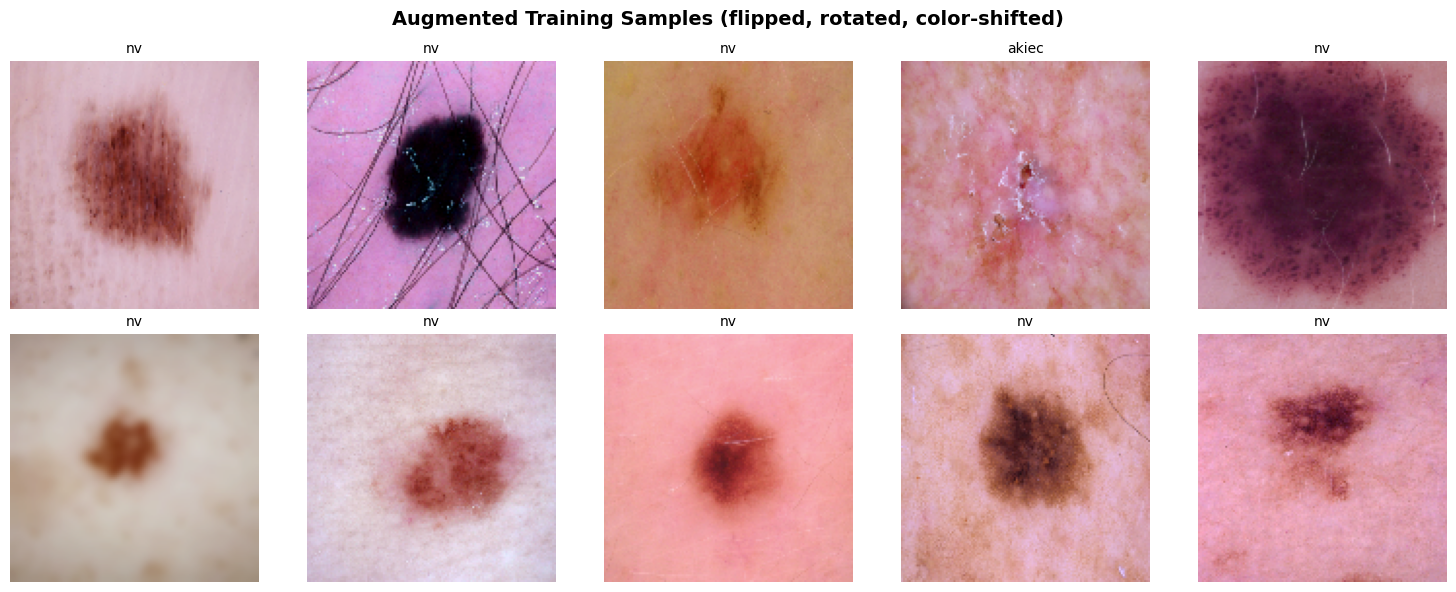

In [6]:
from src.preprocessing import denormalize

# Show a few augmented training samples
fig, axes = plt.subplots(2, 5, figsize=(15, 6))

for i in range(10):
    img, label = train_dataset[i]
    img_display = denormalize(img)  # Undo normalization so we can see the actual colors
    ax = axes[i // 5, i % 5]
    ax.imshow(img_display)
    ax.set_title(CLASS_NAMES[label], fontsize=10)
    ax.axis('off')

plt.suptitle('Augmented Training Samples (flipped, rotated, color-shifted)', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig(RESULTS_DIR / 'augmented_samples.png', dpi=150, bbox_inches='tight')
plt.show()

---
## 2. Build the Model — Transfer Learning

**EfficientNet-B0** is pretrained on ImageNet (14M images). It already knows edges, textures, and colors — we just teach it our 7 skin conditions.

**Two-phase training:**
1. **Phase 1** — Freeze base, train only the classifier head (fast)
2. **Phase 2** — Unfreeze all, fine-tune with lower LR (slower, better)

In [7]:
from src.model import create_model, freeze_base, unfreeze_all, get_model_summary

# Create the model — downloads pretrained weights from ImageNet
model = create_model(MODEL_NAME, NUM_CLASSES, pretrained=True)
print(f'Model: {MODEL_NAME}')
print(f'Output classes: {NUM_CLASSES}')
print()

# Phase 1: Freeze base layers — only the classifier head will train
model = freeze_base(model)
print('After freezing base:')
get_model_summary(model)
print()
print('Only ~9K parameters will train in Phase 1 (the head).')
print('The other 4M parameters stay frozen (pretrained ImageNet features).')

Model: efficientnet_b0
Output classes: 7

After freezing base:
Total parameters:        4,016,515
Trainable parameters:        8,967
Frozen parameters:       4,007,548

Only ~9K parameters will train in Phase 1 (the head).
The other 4M parameters stay frozen (pretrained ImageNet features).


---
## 3. Phase 1 — Classifier Head Only

Train only the head (9K params) with higher LR (1e-3). Fast warm-up — teaches the head what our 7 labels mean.

In [8]:
from src.train import train_model, set_seed

set_seed(SEED)

print('=== PHASE 1: Training classifier head (base frozen) ===')
print('This should be fast even on CPU...\n')

model, history_phase1 = train_model(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    class_weights=class_weights,
    num_epochs=5,           # Just a few epochs for the head
    lr=1e-3,                # Higher LR since only training the head
    patience=3,
    save_name='phase1_head.pth',
)

print('\nPhase 1 complete!')

=== PHASE 1: Training classifier head (base frozen) ===
This should be fast even on CPU...

Training on: cpu

Epoch 1/5
----------------------------------------


Train Loss: 3.8784 | Train Acc: 0.2953
Val   Loss: 3.3345 | Val   Acc: 0.3556
  -> New best model! (val_loss: 3.3345)

Epoch 2/5
----------------------------------------


Train Loss: 2.9631 | Train Acc: 0.3809
Val   Loss: 2.8726 | Val   Acc: 0.3923
  -> New best model! (val_loss: 2.8726)

Epoch 3/5
----------------------------------------


Train Loss: 2.5644 | Train Acc: 0.4278
Val   Loss: 2.5087 | Val   Acc: 0.4330
  -> New best model! (val_loss: 2.5087)

Epoch 4/5
----------------------------------------


Train Loss: 2.3676 | Train Acc: 0.4426
Val   Loss: 2.3728 | Val   Acc: 0.4536
  -> New best model! (val_loss: 2.3728)

Epoch 5/5
----------------------------------------


Train Loss: 2.1136 | Train Acc: 0.4684
Val   Loss: 2.1914 | Val   Acc: 0.4777
  -> New best model! (val_loss: 2.1914)

Best model saved to: D:\Projects\Vision_something\models\phase1_head.pth

Phase 1 complete!


---
## 4. Phase 2 — Full Fine-tuning

Unfreeze all 4M params, lower LR (1e-4) to not destroy pretrained features. Early stopping watches val loss — stops if no improvement for 4 epochs.

In [9]:
# Unfreeze all layers for full fine-tuning
model = unfreeze_all(model)
print('After unfreezing all layers:')
get_model_summary(model)

print()
print('=== PHASE 2: Full fine-tuning ===')
print('This will take longer on CPU — grab a coffee...\n')

model, history_phase2 = train_model(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    class_weights=class_weights,
    num_epochs=NUM_EPOCHS,
    lr=LEARNING_RATE,        # Lower LR for fine-tuning
    patience=EARLY_STOPPING_PATIENCE,
    save_name='best_model.pth',
)

print('\nPhase 2 complete!')

After unfreezing all layers:
Total parameters:        4,016,515
Trainable parameters:    4,016,515
Frozen parameters:               0

=== PHASE 2: Full fine-tuning ===
This will take longer on CPU — grab a coffee...

Training on: cpu

Epoch 1/15
----------------------------------------


Train Loss: 1.9597 | Train Acc: 0.4921
Val   Loss: 1.6665 | Val   Acc: 0.5264
  -> New best model! (val_loss: 1.6665)

Epoch 2/15
----------------------------------------


Train Loss: 1.3800 | Train Acc: 0.5581
Val   Loss: 1.3679 | Val   Acc: 0.5630
  -> New best model! (val_loss: 1.3679)

Epoch 3/15
----------------------------------------


Train Loss: 1.1908 | Train Acc: 0.5943
Val   Loss: 1.1638 | Val   Acc: 0.6284
  -> New best model! (val_loss: 1.1638)

Epoch 4/15
----------------------------------------


Train Loss: 1.0011 | Train Acc: 0.6327
Val   Loss: 1.1451 | Val   Acc: 0.6518
  -> New best model! (val_loss: 1.1451)

Epoch 5/15
----------------------------------------


Train Loss: 0.9276 | Train Acc: 0.6536
Val   Loss: 1.1021 | Val   Acc: 0.6224
  -> New best model! (val_loss: 1.1021)

Epoch 6/15
----------------------------------------


Train Loss: 0.8734 | Train Acc: 0.6787
Val   Loss: 0.9706 | Val   Acc: 0.6818
  -> New best model! (val_loss: 0.9706)

Epoch 7/15
----------------------------------------


Train Loss: 0.8047 | Train Acc: 0.6957
Val   Loss: 0.9865 | Val   Acc: 0.6931
  -> No improvement (1/4)

Epoch 8/15
----------------------------------------


Train Loss: 0.7117 | Train Acc: 0.7131
Val   Loss: 0.8800 | Val   Acc: 0.7165
  -> New best model! (val_loss: 0.8800)

Epoch 9/15
----------------------------------------


Train Loss: 0.6867 | Train Acc: 0.7237
Val   Loss: 0.9170 | Val   Acc: 0.7432
  -> No improvement (1/4)

Epoch 10/15
----------------------------------------


Train Loss: 0.6186 | Train Acc: 0.7371
Val   Loss: 0.9094 | Val   Acc: 0.7278
  -> No improvement (2/4)

Epoch 11/15
----------------------------------------


Train Loss: 0.6131 | Train Acc: 0.7485
Val   Loss: 0.8783 | Val   Acc: 0.7318
  -> New best model! (val_loss: 0.8783)

Epoch 12/15
----------------------------------------


Train Loss: 0.6052 | Train Acc: 0.7515
Val   Loss: 0.9482 | Val   Acc: 0.7312
  -> No improvement (1/4)

Epoch 13/15
----------------------------------------


Train Loss: 0.5300 | Train Acc: 0.7711
Val   Loss: 0.9949 | Val   Acc: 0.7345
  -> No improvement (2/4)

Epoch 14/15
----------------------------------------


Train Loss: 0.4848 | Train Acc: 0.7806
Val   Loss: 0.8913 | Val   Acc: 0.7365
  -> No improvement (3/4)

Epoch 15/15
----------------------------------------


Train Loss: 0.4879 | Train Acc: 0.7947
Val   Loss: 0.8144 | Val   Acc: 0.7725
  -> New best model! (val_loss: 0.8144)

Best model saved to: D:\Projects\Vision_something\models\best_model.pth

Phase 2 complete!


---
## 5. Training Curves

- **Loss** should go down for both train and val
- **Accuracy** should go up
- Gap between train/val = overfitting indicator
- Jump between Phase 1 → Phase 2 is normal (9K → 4M params)

Saved to D:\Projects\Vision_something\results\training_curves.png


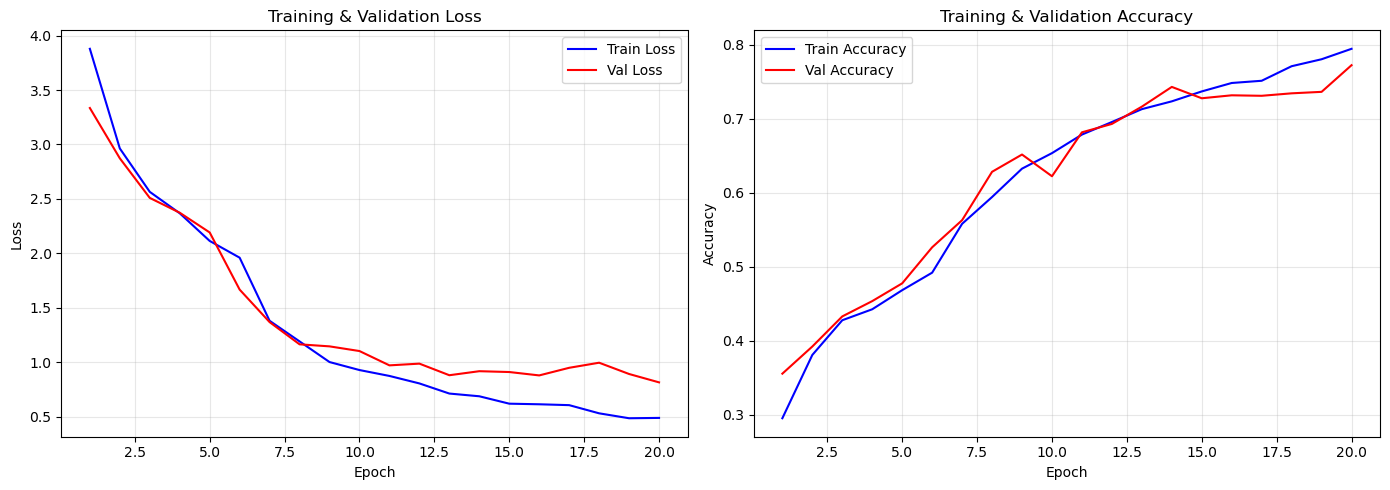


Best val accuracy: 0.7725 (77.3%)
Best val loss: 0.8144
Total epochs trained: 20


In [10]:
# Combine histories from both phases into one timeline
history = {
    'train_loss': history_phase1['train_loss'] + history_phase2['train_loss'],
    'val_loss': history_phase1['val_loss'] + history_phase2['val_loss'],
    'train_acc': history_phase1['train_acc'] + history_phase2['train_acc'],
    'val_acc': history_phase1['val_acc'] + history_phase2['val_acc'],
}

from src.evaluate import plot_training_history

plot_training_history(history, save=True)
print(f'\nBest val accuracy: {max(history["val_acc"]):.4f} ({max(history["val_acc"])*100:.1f}%)')
print(f'Best val loss: {min(history["val_loss"]):.4f}')
print(f'Total epochs trained: {len(history["train_loss"])}')

### Training Results

Phase 1 reached ~48% (head only). Phase 2 pushed to **77.3% val / 75.8% test**. Slight overfitting (train loss 0.49 vs val 0.81) but early stopping kept it in check. Solid for CPU at 128x128 — SOTA on HAM10000 is ~85-90% with GPUs.

---
## 6. Test Set Evaluation

- **Precision** — "When the model says melanoma, how often is it right?"
- **Recall** — "Of all actual melanomas, how many did it catch?"
- **F1** — Balance of both. For medical AI, **recall matters more** (don't miss a melanoma).

### Per-class Results

- **nv** — 95% precision, 78% recall. Very reliable when it says "mole"
- **mel** — 42% precision, 71% recall. Cautious (many false positives) but catches most melanomas — good for safety
- **vasc** — 86% recall despite only 22 test samples. Distinctive red/purple appearance helps
- **df** — 76% recall for the rarest class (17 samples). Weighted loss worked!

In [11]:
from src.evaluate import get_predictions, print_classification_report

device = torch.device('cpu')
model = model.to(device)

# Get predictions on the test set
y_true, y_pred, y_probs = get_predictions(model, test_loader, device)

print('=== TEST SET RESULTS ===')
print()
print_classification_report(y_true, y_pred)

# Overall accuracy
accuracy = (y_true == y_pred).mean()
print(f'\nOverall test accuracy: {accuracy:.4f} ({accuracy*100:.1f}%)')

Predicting: 100%|██████████| 94/94 [01:46<00:00,  1.13s/it]

=== TEST SET RESULTS ===

                      precision    recall  f1-score   support

   Actinic Keratosis       0.58      0.65      0.62        49
Basal Cell Carcinoma       0.64      0.69      0.66        77
    Benign Keratosis       0.58      0.74      0.65       165
      Dermatofibroma       0.59      0.76      0.67        17
            Melanoma       0.42      0.71      0.53       167
   Melanocytic Nevus       0.95      0.78      0.86      1006
     Vascular Lesion       0.66      0.86      0.75        22

            accuracy                           0.76      1503
           macro avg       0.63      0.74      0.67      1503
        weighted avg       0.82      0.76      0.78      1503


Overall test accuracy: 0.7585 (75.8%)


### Confusion Matrix

Main confusions: **mel ↔ nv** (melanomas look like moles) and **akiec ↔ bkl** (both keratosis types). Vascular lesions are well-separated thanks to their distinct color.

---
## Summary

| Metric | Value |
|--------|-------|
| Test Accuracy | 75.8% |
| Best Val Accuracy | 77.3% |
| Macro F1 | 0.67 |
| Weighted F1 | 0.78 |
| Total Epochs | 20 (5 head + 15 fine-tune) |

**Saved:** `models/best_model.pth`, `results/training_curves.png`, `results/confusion_matrix.png`

**Next** -> `03_evaluation.ipynb` (ROC curves, error analysis) -> `04_gradcam.ipynb` (explainability)

Saved to D:\Projects\Vision_something\results\confusion_matrix.png


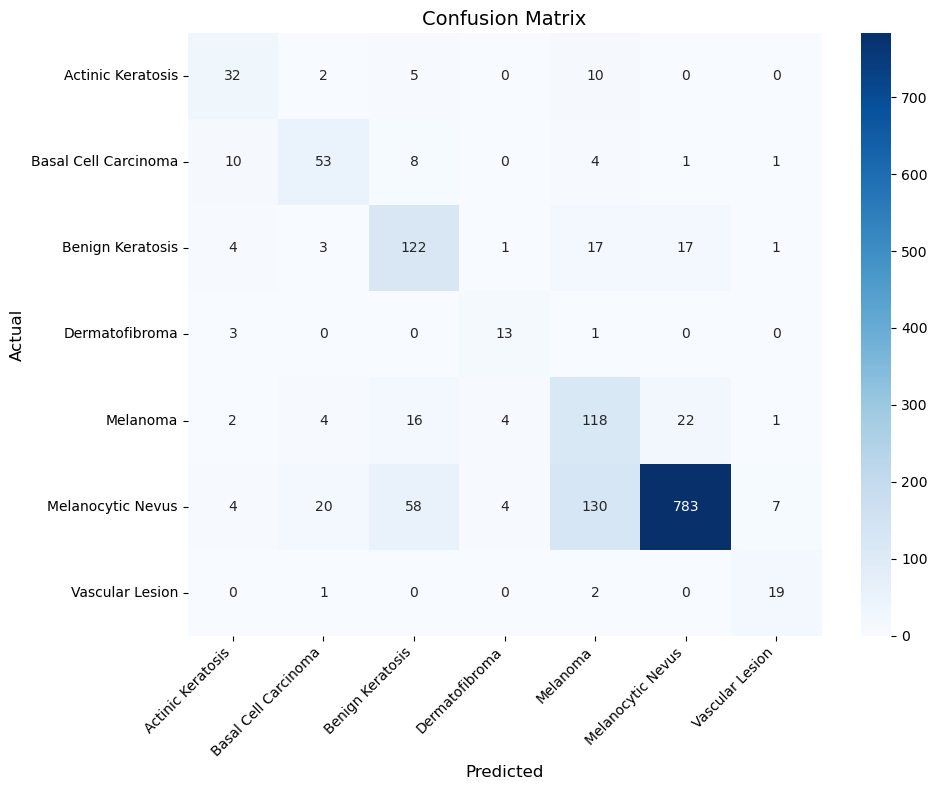

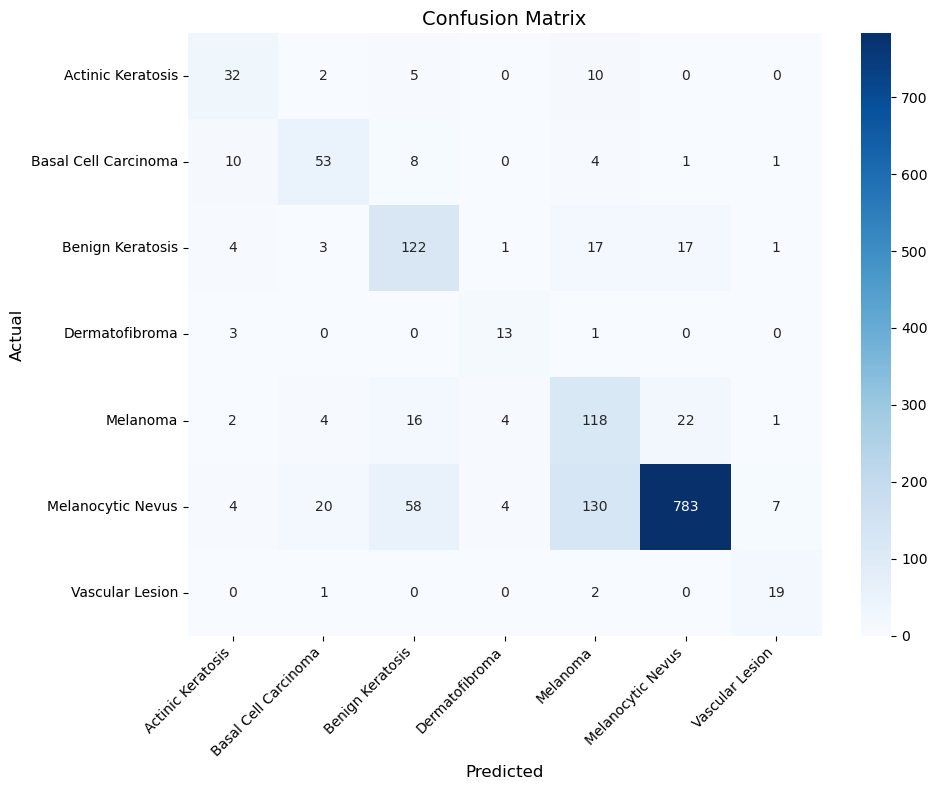

In [12]:
from src.evaluate import plot_confusion_matrix

plot_confusion_matrix(y_true, y_pred, save=True)

In [13]:
# Save results to a JSON file for the README and future reference
import json

test_results = {
    'accuracy': float(accuracy),
    'best_val_loss': float(min(history['val_loss'])),
    'best_val_acc': float(max(history['val_acc'])),
    'total_epochs': len(history['train_loss']),
    'model': MODEL_NAME,
    'image_size': IMAGE_SIZE,
}

with open(RESULTS_DIR / 'training_results.json', 'w') as f:
    json.dump(test_results, f, indent=2)

print('Results saved to results/training_results.json')
print(json.dumps(test_results, indent=2))

Results saved to results/training_results.json
{
  "accuracy": 0.7584830339321357,
  "best_val_loss": 0.8144210465476066,
  "best_val_acc": 0.7725150100066711,
  "total_epochs": 20,
  "model": "efficientnet_b0",
  "image_size": 128
}
